In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.svm import SVC

In [2]:
# Load the datasets
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')

In [3]:
# Merge necessary tables for prediction
data = orders.merge(order_reviews, on='order_id', how='inner')
data = data.merge(order_items, on='order_id', how='inner')
data = data.merge(products, on='product_id', how='inner')
data = data.merge(customers, on='customer_id', how='inner')
data = data.merge(order_payments, on='order_id', how='inner')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106504 entries, 0 to 106503
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       106504 non-null  object 
 1   customer_id                    106504 non-null  object 
 2   order_status                   106504 non-null  object 
 3   order_purchase_timestamp       106504 non-null  object 
 4   order_approved_at              106490 non-null  object 
 5   order_delivered_carrier_date   105407 non-null  object 
 6   order_delivered_customer_date  104229 non-null  object 
 7   order_estimated_delivery_date  106504 non-null  object 
 8   review_id                      106504 non-null  object 
 9   review_score                   106504 non-null  int64  
 10  review_comment_title           12741 non-null   object 
 11  review_comment_message         45569 non-null   object 
 12  review_creation_date          

In [4]:
# Dropping columns not needed for prediction
data.drop(['order_delivered_carrier_date','product_name_lenght', 'review_comment_title', 'review_comment_message', 'product_category_name', 
           'product_id', 'seller_id', 'customer_zip_code_prefix', 'customer_city',  'order_approved_at', 'review_id',
            'customer_id', 'customer_unique_id', 'review_creation_date', 'shipping_limit_date'], axis=1, inplace=True)

In [5]:
data.head()

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_answer_timestamp,order_item_id,price,freight_value,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,4,12/10/2017 03:43,1,29.99,8.72,...,4.0,500.0,19.0,8.0,13.0,SP,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,4,12/10/2017 03:43,1,29.99,8.72,...,4.0,500.0,19.0,8.0,13.0,SP,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,4,12/10/2017 03:43,1,29.99,8.72,...,4.0,500.0,19.0,8.0,13.0,SP,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,4,08/08/2018 18:37,1,118.70,22.76,...,1.0,400.0,19.0,13.0,19.0,BA,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,5,22/08/2018 19:07,1,159.90,19.22,...,1.0,420.0,24.0,19.0,21.0,GO,1,credit_card,3,179.12


In [6]:
data1 = data.copy()

In [7]:
# Ensure columns are in datetime format
data1['order_estimated_delivery_date'] = pd.to_datetime(data1['order_estimated_delivery_date'])
data1['order_delivered_customer_date'] = pd.to_datetime(data1['order_delivered_customer_date'])
data1['order_purchase_timestamp'] = pd.to_datetime(data1['order_purchase_timestamp'])
data1['review_answer_timestamp'] = pd.to_datetime(data1['review_answer_timestamp'],  format="%d/%m/%Y %H:%M")

# Calculate delivery features
data1['delivery2'] = (data1['order_estimated_delivery_date'] - data1['order_delivered_customer_date']).dt.days
data1['delivery1'] = (data1['order_delivered_customer_date'] - data1['order_purchase_timestamp']).dt.days
data1['delivery3'] = (data1['review_answer_timestamp'] - data1['order_delivered_customer_date']).dt.days
data1['total_payment'] = data1.groupby('order_id')['payment_value'].transform('sum')
data1['product_count'] = data1.groupby('order_id')['order_item_id'].transform('count')
data1['average_product_value'] = data1['total_payment'] / data1['product_count']

In [8]:
# Dropping columns not needed for prediction
data1.drop(['order_estimated_delivery_date','order_delivered_customer_date', 'order_purchase_timestamp',
           'review_answer_timestamp', 'order_id'], axis=1, inplace=True)

In [9]:
#Null values
print(data1.isnull().sum())

order_status                     0
review_score                     0
order_item_id                    0
price                            0
freight_value                    0
product_description_lenght    1528
product_photos_qty            1528
product_weight_g                20
product_length_cm               20
product_height_cm               20
product_width_cm                20
customer_state                   0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
delivery2                     2275
delivery1                     2275
delivery3                     2275
total_payment                    0
product_count                    0
average_product_value            0
dtype: int64


In [10]:
#Drop or fill null values
data1['delivery1'] = data1['delivery1'].fillna(0.0)
data1['delivery2'] = data1['delivery2'].fillna(0.0) 
data1['delivery3'] = data1['delivery3'].fillna(0.0)

data1['product_description_lenght'] = data1['product_description_lenght'].fillna(data1['product_description_lenght'].median())
data1['product_photos_qty'] = data1['product_photos_qty'].fillna(data1['product_photos_qty'].median())

data1 = data1.dropna(subset=['product_height_cm'])

In [11]:
#See the updated null values
print(data1.isnull().sum())

order_status                  0
review_score                  0
order_item_id                 0
price                         0
freight_value                 0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
customer_state                0
payment_sequential            0
payment_type                  0
payment_installments          0
payment_value                 0
delivery2                     0
delivery1                     0
delivery3                     0
total_payment                 0
product_count                 0
average_product_value         0
dtype: int64


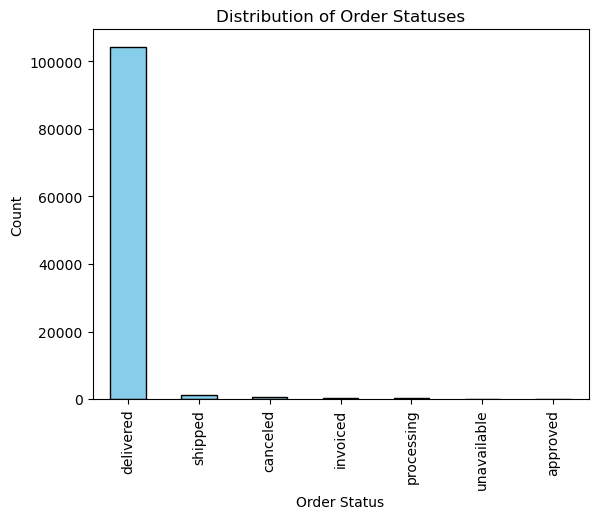

In [12]:
#Plot the different type of order status
order_status_counts = data1['order_status'].value_counts()
order_status_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Order Statuses')
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.show()

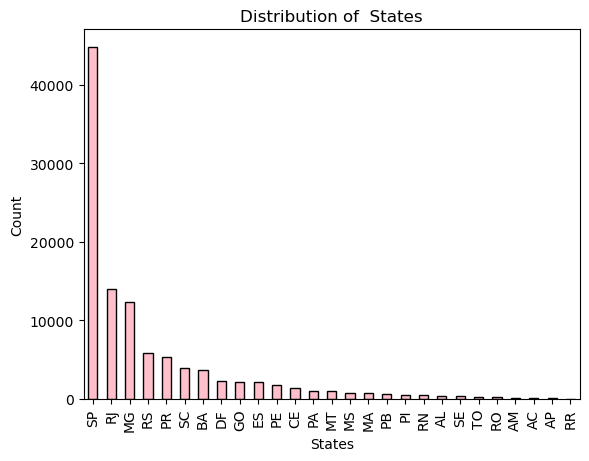

In [13]:
#Plot the states
order_status_counts = data1['customer_state'].value_counts()
order_status_counts.plot(kind='bar', color='pink', edgecolor='black')
plt.title('Distribution of  States')
plt.xlabel('States')
plt.ylabel('Count')
plt.show()

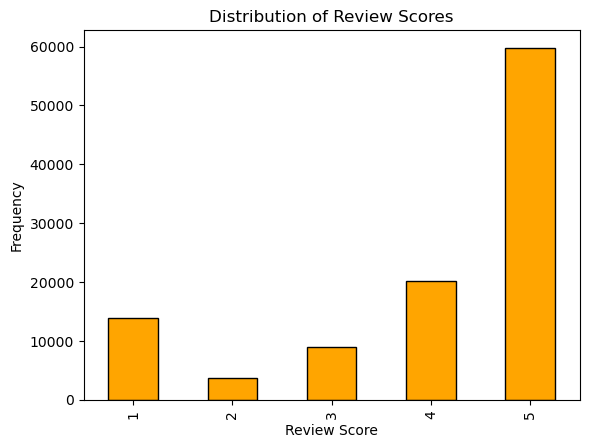

In [14]:
#Plot the review scores
data1['review_score'].value_counts().sort_index().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

/var/folders/xr/fxzmlkxj7hj_7ywm0m_3sf8w0000gn/T/ipykernel_37245/4172601714.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_score', y='delivery1', data=data1, palette='Set2')


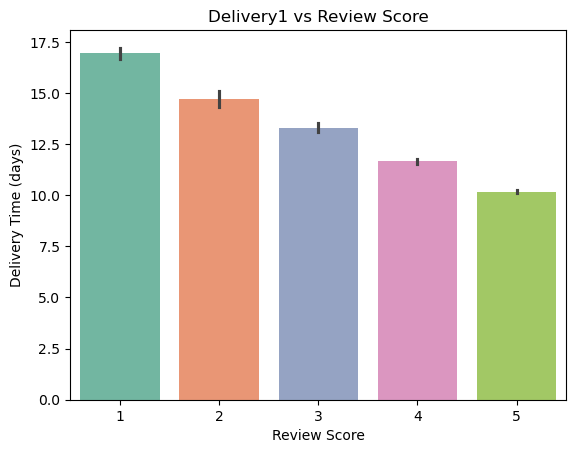

In [15]:
#Plot the delivery_time1 vs the review _score
sns.barplot(x='review_score', y='delivery1', data=data1, palette='Set2')

plt.title('Delivery1 vs Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (days)')
plt.show()

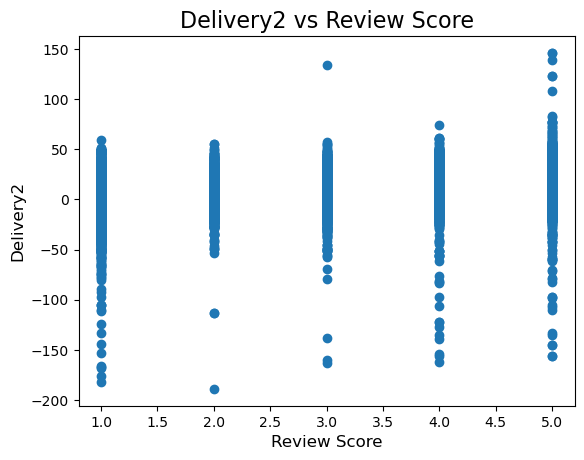

In [16]:
#Plot the delivery_time2 vs the review_score
plt.scatter(data=data1, x='review_score', y='delivery2')
plt.title('Delivery2 vs Review Score', fontsize=16)
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Delivery2', fontsize=12)
plt.show()

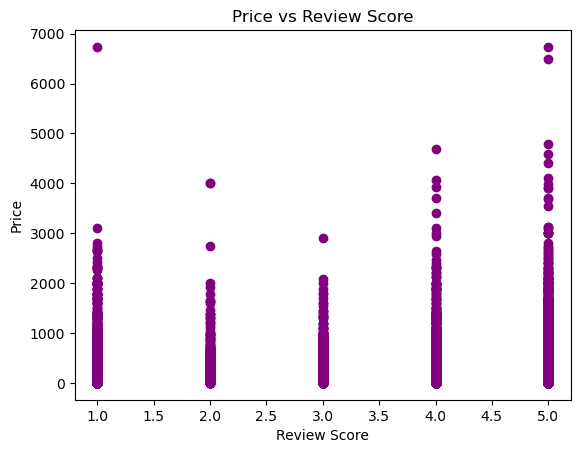

In [17]:
#Plot the price vs the review_score
plt.scatter(data1['review_score'], data1['price'], alpha=1, color='purple')
plt.title('Price vs Review Score')
plt.xlabel('Review Score')
plt.ylabel('Price')
plt.show()

In [18]:
#Standardise the numerical data

# Initialize scalers
normalizer = MinMaxScaler()
standardizer = StandardScaler()

features_to_standardize = ['delivery1', 'delivery2', 'delivery3', 'price', 'payment_value', 'total_payment', 'average_product_value',
                           'product_photos_qty', 'product_weight_g', 'product_count', 'price', 'freight_value', 'product_description_lenght',
                           'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm' ]

# Standardize numerical features
data1[features_to_standardize] = standardizer.fit_transform(data1[features_to_standardize])


print(data1[features_to_standardize].head())

   delivery1  delivery2  delivery3     price  payment_value  total_payment  \
0  -0.397597  -0.378402  -0.135702 -0.492489      -0.578094      -0.196102   
1  -0.397597  -0.378402  -0.135702 -0.492489      -0.638368      -0.196102   
2  -0.397597  -0.378402  -0.135702 -0.492489      -0.576336      -0.196102   
3   0.131010  -0.575756  -0.135702 -0.008932      -0.116915      -0.132829   
4  -0.291875   0.608370   0.236365  0.215649       0.023899      -0.109639   

   average_product_value  product_photos_qty  product_weight_g  product_count  \
0              -0.599507            1.060679         -0.426076       0.712152   
1              -0.599507            1.060679         -0.426076       0.712152   
2              -0.599507            1.060679         -0.426076       0.712152   
3              -0.117288           -0.694821         -0.452594      -0.332463   
4               0.023975           -0.694821         -0.447290      -0.332463   

      price  freight_value  product_descript

In [19]:
#Encode the categorical features

# One-hot encoding
data_encoded = pd.get_dummies(data1, columns=['customer_state'], prefix='state', drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['order_status'], prefix='status', drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['payment_type'], prefix='payment', drop_first=True)

In [20]:
# Convert the score in a binary variable
for index, value in data_encoded['review_score'].items():
    if value in [1, 2, 3]:
        data_encoded.at[index, 'review_score'] = 0  #if 1,2,3 it will be 0
    else:
        data_encoded.at[index, 'review_score'] = 1  ##if 4,5 it will be 1


In [21]:
# Check class distribution
print(data_encoded['review_score'].value_counts())

review_score
1    79907
0    26577
Name: count, dtype: int64


In [22]:
#Oversampling the dataset

target = 'review_score'
X = data_encoded.drop(columns=[target])  # Features
y = data_encoded[target]  # Target column

print("Original dataset shape:", Counter(y))

# Dataset splitted into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set class distribution before SMOTE:", Counter(y_train))

# SMOTE to the training data
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Training set class distribution after SMOTE:", Counter(y_train))

Original dataset shape: Counter({1: 79907, 0: 26577})
Training set class distribution before SMOTE: Counter({1: 55927, 0: 18611})
Training set class distribution after SMOTE: Counter({1: 55927, 0: 33556})


In [23]:
# Find the most important features to use into the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
features = X_train.columns

# Sort features by importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

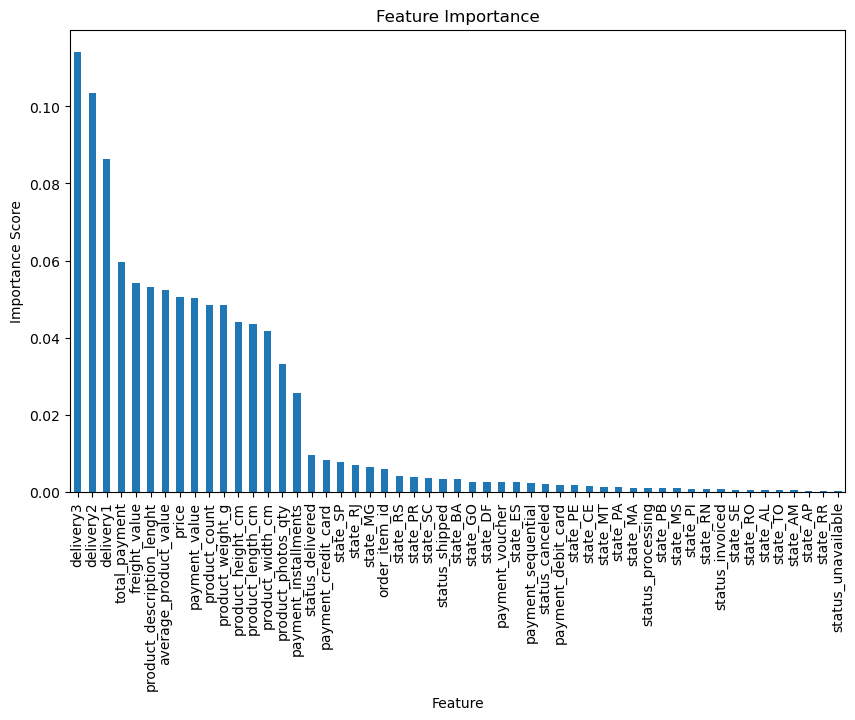

In [24]:
#display the features
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.show()

In [25]:
#Drop the features under the threshold
threshold = 0.01

# Get the feature importance scores from the model
important_features = [feature for feature, importance in zip(X_train.columns, rf.feature_importances_) if importance >= threshold]

# Filter the datasets to include only important features
X_train = X_train[important_features]
X_test = X_test[important_features]

# Print the features
print(f"Selected Features: {important_features}\n")

Selected Features: ['price', 'freight_value', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_installments', 'payment_value', 'delivery2', 'delivery1', 'delivery3', 'total_payment', 'product_count', 'average_product_value']



In [26]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (89483, 16), X_test shape: (31946, 16)


In [27]:
# Model Building

Gradient Boosting Accuracy: 80.17%
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.30      0.43      7966
           1       0.81      0.97      0.88     23980

    accuracy                           0.80     31946
   macro avg       0.78      0.63      0.65     31946
weighted avg       0.79      0.80      0.77     31946



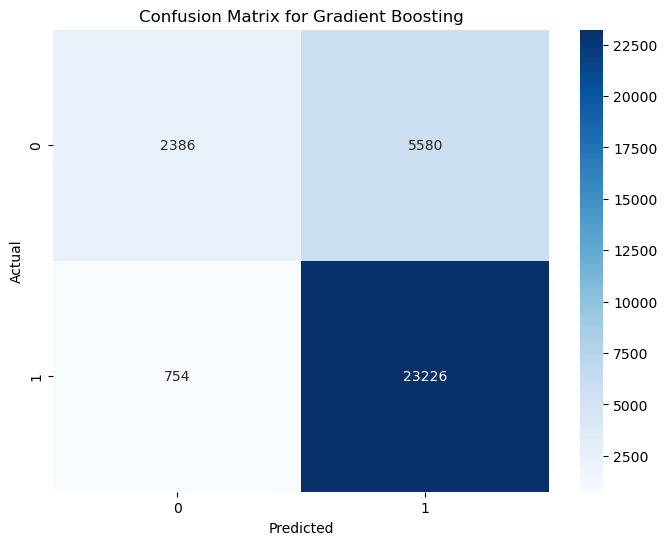

In [28]:
# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Train the model
gb_clf.fit(X_train, y_train)

# Make predictions
y_pred1 = gb_clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred1)
print(f"Gradient Boosting Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred1))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()

Gradient Boosting ROC-AUC: 0.74


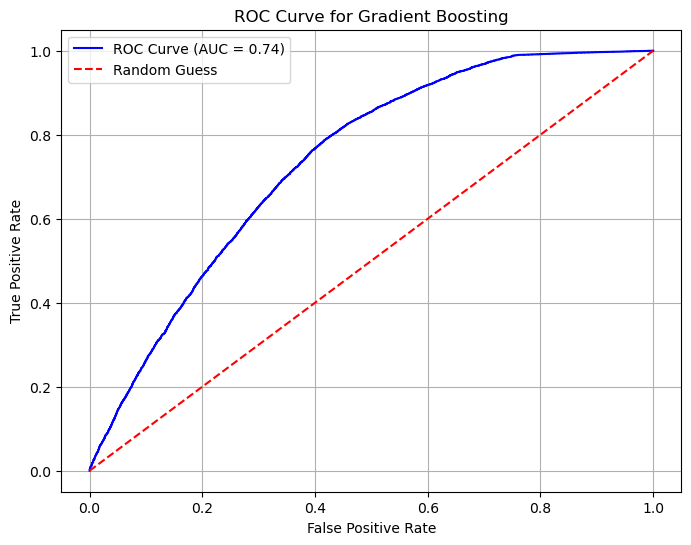

In [29]:
# Predict probabilities for the positive class
y_proba1 = gb_clf.predict_proba(X_test)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba1)
print(f"Gradient Boosting ROC-AUC: {roc_auc:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Gradient Boosting")
plt.legend()
plt.grid()
plt.show()

/Users/francescocapo/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 82.47%
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.38      0.52      7966
           1       0.83      0.97      0.89     23980

    accuracy                           0.82     31946
   macro avg       0.82      0.68      0.71     31946
weighted avg       0.82      0.82      0.80     31946



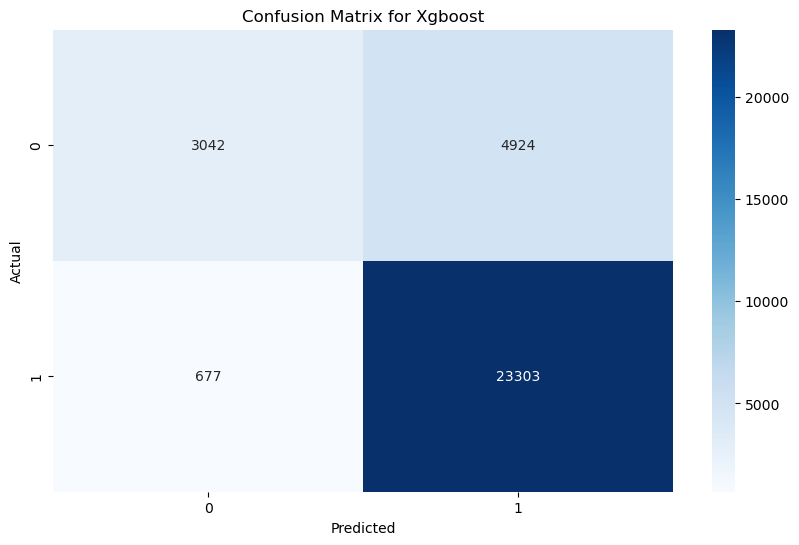

In [30]:
# XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric="logloss", random_state=42)

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Xgboost')
plt.show()

Tuned XGBoost ROC-AUC: 0.77


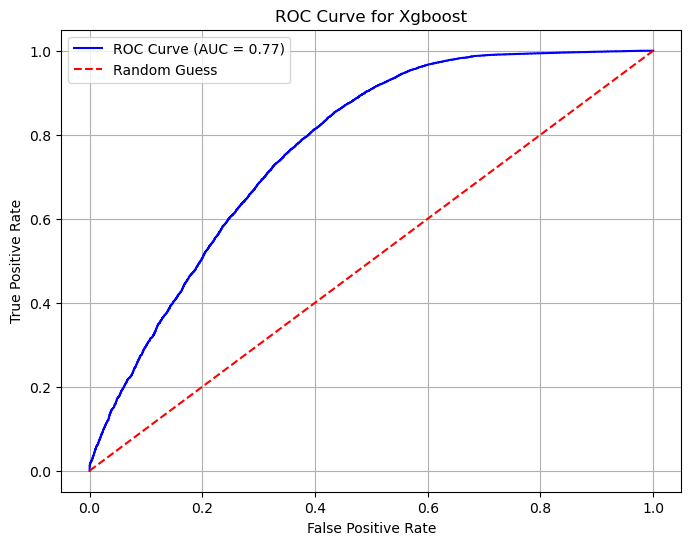

In [31]:
# Predict probabilities for the positive class
y_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Tuned XGBoost ROC-AUC: {roc_auc:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Xgboost")
plt.legend()
plt.grid()
plt.show()

Accuracy: 85.45%
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.51      0.63      7966
           1       0.86      0.97      0.91     23980

    accuracy                           0.85     31946
   macro avg       0.85      0.74      0.77     31946
weighted avg       0.85      0.85      0.84     31946



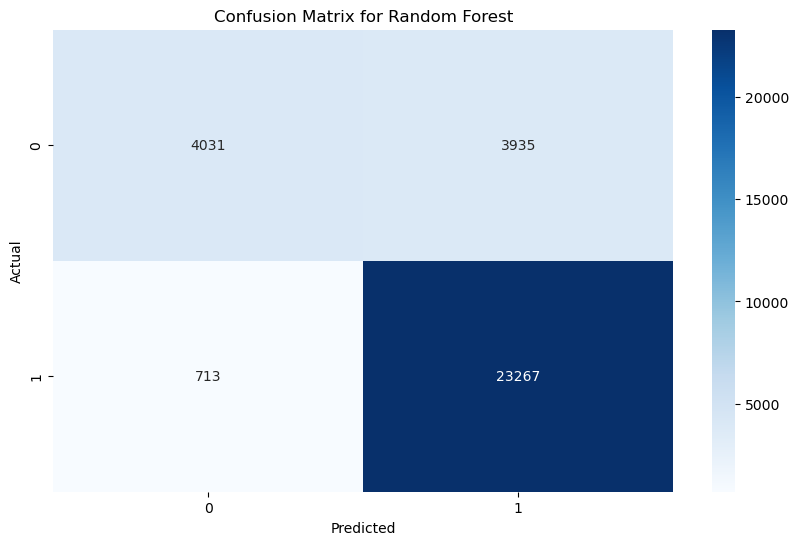

In [32]:
#Random Forest

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions
y_best_pred = rf_classifier.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_best_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_best_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_best_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Tuned RandomForestClassifier ROC-AUC: 0.81


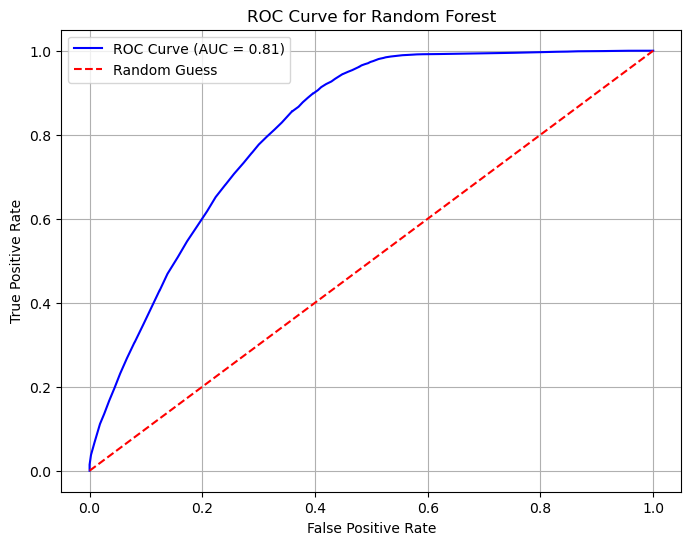

In [33]:
# Predict probabilities for the positive class
y_best_proba = rf_classifier.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_best_proba)
print(f"Tuned RandomForestClassifier ROC-AUC: {roc_auc:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_best_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend()
plt.grid()
plt.show()